One-Dimensional-Kalman-Filters

In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt


In [2]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

Gaussian(mean=3.4, var=10.1)
Gaussian(mean=4.5, var=0.04000000000000001)


In [3]:
zs = [1.3535959735108178, 1.8820653967131618, 4.341047429453569, 7.156332673205118, 6.938695089418526,
 6.843912342028484, 9.846824080052299, 12.553482049375292, 16.2730841073834, 14.800411177015299,
 16.53802277090776, 15.269434886383538, 17.998112285019232, 16.629295487587115, 17.1377679268381,
 23.589489061545798, 20.65006487184912, 23.236590145275883, 21.766974549446164, 24.28564376387599]

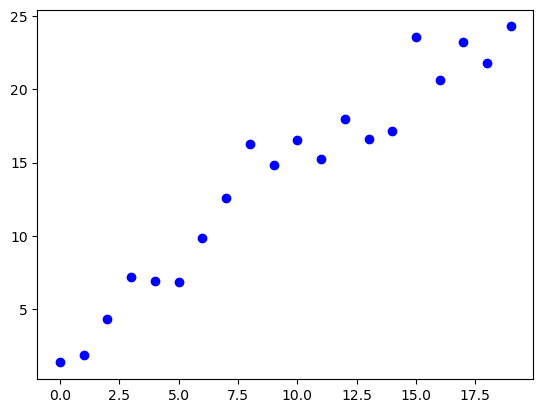

In [4]:
plt.plot(zs, marker='o', linestyle='', color='b');

In [4]:
np.random.seed(13)
x = gaussian(0., 20.**2) # dog's position, N(0, 20**2)
process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor measurement
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x

In [6]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

In [7]:
# create list of measurements
N = 20
N_ = np.arange(N)
xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    xs[i] = x

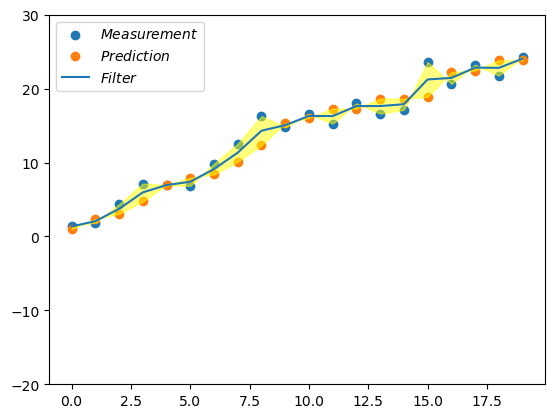

In [8]:
plt.scatter(N_, zs, label='$Measurement$')
plt.scatter(N_, priors[:, 0], label='$Prediction$')
plt.plot(N_, xs[:, 0], label='$Filter$')
plt.ylim(-20,30)
plt.fill_between(N_, zs, priors[:, 0], color='yellow',  alpha=0.5)
plt.legend()

In [ ]:
for priors,update,measurement in zip(priors,xs,zs):
    print (priors,'|     ',update,'|    ',measurement)


In [ ]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

The sensor for the thermometer outputs a voltage that corresponds to the temperature that is being measured. We have read the manufacturer's specifications for the sensor, and it tells us that the sensor exhibits white noise with a standard deviation of 0.13 volts.

In [ ]:
#  simulate the temperature sensor measurement 
def volt(voltage, std):
    return voltage + (randn() * std)


N = 50
N_ = np.arange(N)

voltage_std = .13
process_var = .05**2
actual_voltage = 16.3
x = gaussian(30, 2000)

process_model = gaussian(temp_change, process_var)
zs = [volt(actual_voltage, voltage_std)  for i in range(N)]

As always, we will trust in the math. We have no known movement, so we will set that to zero.
However, that means that we are predicting that the temperature will never change. If that is true, then over time we should become extremely confident in our results. Once the filter has enough measurements it will become very confident that it can predict the subsequent temperatures, and this will lead it to ignoring measurements that result due to an actual temperature change. 
This is called a smug filter, and is something you want to avoid. So we will add a bit of error to our prediction step to tell the filter not to discount changes in voltage over time. 

In [ ]:
temp_change = 0
#process_var = 0
process_model = gaussian(temp_change, process_var)
zs = [volt(actual_voltage, voltage_std)  for i in range(N)]

In [ ]:
ps = []
estimates = []
priors = []
## cycle of predicting and updating

for z in zs:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)
    priors.append(prior.mean)

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.arange(N), zs, 'g.', label='Measurement')
ax.plot(np.arange(N), estimates, 'b', label='Prediction')
ax.plot(np.arange(N), priors, 'r.', label='Measurement')

ax.set_ylim(16, 17)
fig, ax = plt.subplots()
ax.plot(np.arange(N), ps, 'g.-', label='Variance')

#ax.plot(test['date'], test['data'], 'b-', label='Test')
#ax.plot(test['date'], test['pred_last_season'], 'r--', label='Predicted')
#ax.set_xlabel('Date')
#ax.set_ylabel('Earnings per share (USD)')
#ax.axvspan(80, 83, color='#808080', alpha=0.2)

Multivariate KF :  only work with one variable or dimension.
    This provide no way to represent multidimensional data, such as the position and velocity of a dog in a field. Position and velocity are related to each other.

Covariance describes how much two variables vary together. Covariance is short for correlated variances. 
In other words, variance is a measure for how a population vary amongst themselves, and covariance is a measure for how much two variables change in relation to each other. 
For example, as height increases weight also generally increases. These variables are correlated. They are positively correlated because as one variable gets larger so does the other.
As the outdoor temperature decreases home heating bills increase.

Correlation allows prediction. If you are significantly taller than me I can predict that you also weigh more than me. As winter comes I predict that I will be spending more to heat my house.

In [ ]:
height = [60, 62, 63, 65, 65.1, 68, 69, 70, 72, 74]
weight = [95, 120, 127, 119, 151, 143, 173, 171, 180, 210]
plt.plot(height,weight, 'o')

In [ ]:
import numpy as np

# Data for height (in inches) and weight (in pounds)
height = [60, 62, 63, 65, 65.1, 68, 69, 70, 72, 74]
weight = [95, 120, 127, 119, 151, 143, 173, 171, 180, 210]

# Calculate the covariance matrix
cov_matrix = np.cov(height, weight)

# Extract individual elements from the covariance matrix
variance_height = cov_matrix[0, 0]
variance_weight = cov_matrix[1, 1]
covariance_height_weight = cov_matrix[0, 1]

# Print the results
print("Covariance Matrix:")
print(cov_matrix)
print("\nInterpretation:")
print(f"Variance of height: {variance_height:.3f}")
print(f"Variance of weight: {variance_weight:.3f}")
print(f"Covariance between height and weight: {covariance_height_weight:.3f}")



# The reason you're seeing a discrepancy is due to different definitions of variance in NumPy's np.var and
# np.cov

In [ ]:
from numpy.random import randn
X = np.linspace(1, 10, 1000) + randn(1000)*2
Y = np.linspace(1, 5, 1000) + randn(1000)
plt.scatter(X, Y)
print(np.cov(X, Y))

In [ ]:
X = randn(100000)
Y = randn(100000)
plt.scatter(X, Y)
print(np.cov(X, Y))

In [ ]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

Predict Step 
1. Design State Variable :
    We previously tracked a dog in one dimension by using a Gaussian. The mean 
 represented the most likely position, and the variance represented the probability distribution of the position. 
The position is the state of the system, the state variable.

In this problem we will be tracking both the position and velocity of the dog. 

State variables can either be observed variables - directly measured by a sensor, or hidden variables - inferred from the observed variables.
For our problem the sensor only reads position, so position is observed and velocity is hidden. 


state vectro x[x, dx/dt], 
coincidentally have the same name. If we were tracking the dog in the y-axis
             x[y, dy/dt]

In [ ]:
2. Design State Covariance: matrix P
    We need to set the variances to reasonable values.
    
    if we are quite uncertain about the initial position. 500
    Top speed for a dog is around 21 m/s, so in the absence of any other information about the velocity we can set
    
    3 sigma = 21 , sigma 7, variance = (sigma)**2 = 49

In [ ]:
P = np.diag([500., 49.])
P

# the position and velocities are correlated. But how correlated are they for a dog?
# no idea. we will see the filter computes this for us

In [ ]:
# univariate , multivariate
x = np.array([10.0, 4.5])  # x = np.array([10.0, 4.5]) np.array([[10., 4.5]]).T
P = np.diag([500., 49.])
dt = 0.1
F = np.array([[1, dt],
              [0, 1]])

B = 0
u = 0
H = np.array([[1., 0.]])
R = np.array([[5.]])
R

In [ ]:
def Q_discrete_white_noise(dim, dt=1., var=1.):
    if dim == 2:
        Q = [[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]]
    return Q    
        
#We know the fundamental matrix for Newtonian systems is

    
    

In [ ]:
from scipy.linalg import inv

N = 50

dt = 1.
R_var = 10
Q_var = 0.01
track, zs = compute_dog_data(R_var, Q_var, N)
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

xs, cov = [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)
    
    
xs, cov = np.array(xs), np.array(cov)

In [ ]:

fig, ax = plt.subplots()

ax.plot(np.arange(N), xs[:, 0], 'g-', label='filter')
ax.plot(np.arange(N), track, 'b', label='track')
ax.plot(np.arange(N), zs, 'r.', label='Measurement')

ax.set_ylim(-50, 60);
# Add a legend
ax.legend()

In [ ]:
position_variances = cov[:, 0, 0]  # Variance of position
velocity_variances = cov[:, 1, 1]  # Variance of velocity

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Position variance plot
axes[0].plot(position_variances, label="Position Variance", color="blue")
axes[0].set_ylabel("Variance")
axes[0].set_title("Position Variance over Time")
axes[0].grid()
axes[0].legend()

# Velocity variance plot
axes[1].plot(velocity_variances, label="Velocity Variance", color="orange")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Variance")
axes[1].set_title("Velocity Variance over Time")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
position_velocity_covariance = cov[:, 0, 1]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(position_velocity_covariance, label="Covariance P[0,1] (Position-Velocity)", color="green")
plt.xlabel("Time Step")
plt.ylabel("Covariance")
plt.title("Evolution of Position-Velocity Covariance (P[0,1])")
plt.grid()
plt.legend()
plt.show()

In [ ]:
At the start, the Kalman filter has little information about the true state, so the initial uncertainty in position and velocity is high.
As more measurements are incorporated, the Kalman filter refines its estimates for both position and velocity.

In [ ]:
# Extract position estimates and variances
position_estimates = xs[:, 0]
position_variance = cov[:, 0, 0]
position_std = np.sqrt(position_variance)

# Calculate confidence bounds
upper_bound = position_estimates + 3*position_std
lower_bound = position_estimates - 3*position_std

# Plot
plt.figure(figsize=(10, 6))
plt.plot(track, label="True Position", color="green", linestyle="dashed")
plt.plot(zs, label="Measurements", color="red", alpha=0.5, linestyle="dotted")
plt.plot(position_estimates, label="Filter Estimate", color="blue")
plt.fill_between(
    range(len(position_estimates)), lower_bound, upper_bound, 
    color="blue", alpha=0.2, label="3 Std Deviation"
)

plt.xlabel("Time Step")
plt.ylabel("Position")
plt.title("Position Estimates with 3 Std Deviation")
plt.legend()
plt.grid()
plt.show()


In [ ]:
We will begin by tracking a robot in a 2D space, such as a field or warehouse. We will start with a simple noisy sensor that outputs noisy 
 (x,y)coordinates which we will need to filter to generate a 2D track.

let's start with a very simple sensor, one that simulates tracking an object traveling in a straight line. It is initialized with the initial position, velocity, and noise standard deviation. 

In [ ]:
from numpy.random import randn

class PosSensor():
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = [vel[0], vel[1]]
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pos, vel = (4, 3), (2, 1)
sensor = PosSensor(pos, vel, noise_std=1)
ps = np.array([sensor.read() for _ in range(50)])


fig, ax = plt.subplots()

ax.plot(ps[: , 0] , ps[: , 1] , 'g.', label='Measurement')


In [ ]:
F = np.array([[1, dt, 0,  0],
              [0,  1, 0,  0],
              [0,  0, 1, dt],
              [0,  0, 0,  1]])

In [ ]:
def Q_discrete_white_noise(dim, dt=1., var=1.):
    if dim == 2:
        Q = np.array ([[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]])
    return Q * var   

In [ ]:
B = 0
u = 0

In [ ]:
H = np.array([[1/0.3048, 0, 0,        0],
                      [0,        0, 1/0.3048, 0]])

In [ ]:
x = np.array([[0, 0, 0, 0]]).T    
P = np.eye(4) * 500 # Return a 2-D array with ones on the diagonal and zeros elsewhere.

In [ ]:
P

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag, inv
from numpy.random import randn


# x = [x , x_ , y, y_]
dt = 1

R_std = 0.35
Q_std = 0.04

N = 30
sensor = PosSensor((0, 0), (2, .2), noise_std=R_std)
zs = []
zs = np.array([sensor.read() for _ in range(N)])


F = np.array([[1, dt, 0,  0],
              [0,  1, 0,  0],
              [0,  0, 1, dt],
              [0,  0, 0,  1]])

def Q_discrete_white_noise(dim, dt=1., var=1.):
    if dim == 2:
        Q = np.array ([[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]])
    return Q * var   
        

x = np.array([[0, 0, 0, 0]]).T    
P = np.eye(4) * 500
from scipy.linalg import block_diag

Q_var = 0.001
q = Q_discrete_white_noise(dim=2, dt=dt, var= Q_std **2)
Q = block_diag(q, q)

B = 0
u = 0

H = np.array([[1/0.3048, 0, 0,        0],
                      [0,        0, 1/0.3048, 0]])
R = np.eye(2) * R_std**2


In [ ]:
zs

In [ ]:
# Kalman filter loop
position_mean = []  # Estimated states
position_cov = []  # Covariance estimates
for z in zs:
    # Predict step
    x = F @ x
    x = x.astype(np.float64)
    P = F @ P @ F.T + Q
    
    # Update step
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)  # Kalman gain (4x2 matrix)
    y = z.reshape(2, 1) - H @ x  # Measurement residual (2x1 vector) working with two sensors, so the measurement vector z is a 2D array (shape (2, 1)), but your state vector x is a 4D array (shape (4, 1))
    x += K @ y  # Update state estimate (4x1 vector)
    P = P - K @ H @ P  # Update covariance estimate
    
    position_mean.append(x)
    position_cov.append(P)

position_mean = np.array(position_mean)  # Convert to array for plotting
position_cov = np.array(position_cov)
#K.dtype
# Convert measurements to meters and plot
#zs *= 0.3048 

In [ ]:
zs *= 0.3048 # convert to meter
fig, ax = plt.subplots()

ax.plot(position_mean[: , 0], position_mean[:, 2], 'g-', label='filter')
ax.plot(zs[: , 0], zs[:, 1], 'r.', label='Measurement')
plt.xlim(0, 20)
plt.ylim(-3.5,5)


In [ ]:
#position_cov
aa = position_cov[29, : ]
np.diag(aa)

In [ ]:
# The rest of the terms are for similarly independent variables.

In [ ]:
qualitatively by plotting the track and the Kalman filter output and eyeballing the results.

the system covariance matrix  contains the computed variance and covariances for each of the state variables. t
he diagonal contains the variance.  roughly 99% of all measurements fall within  if the noise is Gaussian.

In [ ]:
So we can evaluate the filter by looking at the residuals between the estimated state and actual state and comparing them to the standard deviations which we derive from 
If the filter is performing correctly 99% of the residuals will fall within 
 this is only true for simulated systems. Real sensors are not perfectly Gaussian, and you may need to expand your criteria to, say, 
5 sigma with real sensor data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag, inv
from numpy.random import randn

# Define the PosSensor class
class PosSensor:
    def __init__(self, pos=(0, 0), vel=(2, 0.2), noise_std=0.35):
        self.vel = [vel[0], vel[1]]
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

# Initialize parameters
dt = 1
R_std = 0.35
Q_std = 0.04
N = 30

sensor = PosSensor((0, 0), (2, 0.2), noise_std=R_std)
zs = np.array([np.array(sensor.read()) for _ in range(N)])  # Measurements

# State transition and measurement matrices
F = np.array([[1, dt, 0,  0],
              [0,  1, 0,  0],
              [0,  0, 1, dt],
              [0,  0, 0,  1]])

H = np.array([[1, 0, 0,  0],
              [0, 0, 1,  0]])

def Q_discrete_white_noise(dim, dt=1., var=1.):
    if dim == 2:
        return np.array([[0.25*dt**4, 0.5*dt**3],
                         [0.5*dt**3, dt**2]]) * var

q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
Q = block_diag(q, q)  # Process noise covariance
R = np.eye(2) * R_std**2  # Measurement noise covariance
x = np.array([[0, 0, 0, 0]]).T  # Initial state
P = np.eye(4) * 500  # Initial state covariance

# Kalman filter loop
position_mean = []  # Store state estimates
for z in zs:
    z = np.array(z).reshape(2, 1)  # Convert measurements to column vector

    # Predict step
    x = F @ x
    P = F @ P @ F.T + Q

    # Update step
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x = x + K @ y
    P = P - K @ H @ P

    position_mean.append(x.flatten())

position_mean = np.array(position_mean)

# Extract velocity components
velocity_x = position_mean[:, 1]
velocity_y = position_mean[:, 3]

# Ground truth velocities
true_velocity_x = np.full(N, 2.0)
true_velocity_y = np.full(N, 0.2)

# Plot predicted and actual velocities
time = np.arange(N)

plt.figure(figsize=(10, 5))
plt.plot(time, velocity_x, label='KF Predicted Velocity (X)')
plt.plot(time, true_velocity_x, '--', label='True Velocity (X)', alpha=0.7)
plt.plot(time, velocity_y, label='KF Predicted Velocity (Y)')
plt.plot(time, true_velocity_y, '--', label='True Velocity (Y)', alpha=0.7)
plt.xlabel('Time step')
plt.ylabel('Velocity (m/s)')
plt.title('Kalman Filter Predicted vs. True Velocities')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from numpy.random import randn
# Time step and sensor noise parameters
dt = 0.1
wheel_sigma, ps_sigma = 15,15    # 1.5, 3
position_wheel, position_ps, time = [], [], []

## Generate noisy measurements
for i in range(1, 100):
    time.append(i * dt)
    m0 = i + randn() * wheel_sigma
    m1 = i + randn() * ps_sigma
    position_wheel.append(m0)
    position_ps.append(m1)

position_wheel = np.array(position_wheel)  # Convert to array for plotting
position_ps = np.array(position_ps)
time = np.array(time)  
zs = np.array([position_wheel, position_ps]).T  # Measurement vector from both sensors (transpose to get shape (99, 2))

# Plotting sensor measurements
fig, ax = plt.subplots()
ax.plot(time, position_wheel, 'g.', label='wheel')
ax.plot(time, position_ps, 'r.', label='pos')
ax.legend()
#assume a velocity of 10 m/s with an update rate of 0.1 seconds.

In [ ]:
# Kalman filter setup
F = np.array([[1., dt], [0., 1.]])  # State transition matrix
H = np.array([[1., 0.], [1., 0.]])  # Measurement matrix for two sensors
R = np.diag([wheel_sigma**2, ps_sigma**2])  # Measurement noise covariance
x = np.array([[0.], [1.]])  # Initial state (position, velocity)
P = np.eye(2) * 100  # Initial uncertainty
Q = np.array([[(dt**3) / 3, (dt**2) / 2],
              [(dt**2) / 2, dt]]) * 0.02  # Process noise covariance

# Lists to store filtered positions and residuals
filtered_velocities = []
filtered_positions = []
residuals = []  # Store residuals (y) for each time step
# Kalman filter loop for each time step

for z in zs:  # z is a (2,) vector at each time step
    z = z.reshape(2, 1)  # Convert to a column vector (2, 1)

    # Prediction step
    x = F @ x  # Predict next state (position and velocity)    
    P = F @ P @ F.T + Q  # Predict next state covariance

    # Update step (measurement update)
    S = H @ P @ H.T + R  # Innovation covariance
    K = P @ H.T @ inv(S)  # Kalman gain
    y = z - H @ x  # Measurement residual (innovation)
    x = x + K @ y  # Updated state estimate
    P = P - K @ H @ P  # Update covariance estimate
    # Store the residual and filtered position
    residuals.append(y.flatten())  # Flatten residual to 1D array for storage
    filtered_positions.append(x[0, 0])  # Fused position (position component)
    filtered_velocities.append(x[1, 0])  # Extract velocity component (x[1])


# Convert filtered positions and residuals to numpy arrays for analysis
filtered_positions = np.array(filtered_positions)
residuals = np.array(residuals)
filtered_velocities = np.array(filtered_velocities)

# Plot the filtered position estimates
ax.legend()
plt.show()
# Plotting sensor measurements
fig, ax = plt.subplots()
ax.plot(time, position_wheel, 'g.', label='wheel')
ax.plot(time, position_ps, 'r.', label='pos')
ax.plot(time, filtered_positions, 'b-', label='Kalman filter')
ax.legend()
plt.show()

# Calculate and print the standard deviation of the residuals (y)
fusion_std_residuals = np.std(residuals, axis=0)  # Standard deviation of each residual component
print(f'Fusion standard deviation of residuals (y): {fusion_std_residuals}')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, filtered_velocities, 'b-', label='Kalman Filtered Velocity')
ax.set_title('Filtered Velocity Over Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (units/s)')
ax.legend()
ax.grid()
plt.show()

In [ ]:
import math

sensor_var = 30.
process_var = 2.
pos = gaussian(100., 500.)
process_model = gaussian(1., process_var)

zs, ps = [], []

for i in range(100):
    pos = predict(pos, process_model)

    z = math.sin(i/3.)*2 + randn()*1.2
    zs.append(z)
    
    pos = update(pos, gaussian(z, sensor_var))
    ps.append(pos.mean)

plt.plot(zs, c='r', linestyle='dashed', label='measurement')
plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best');

This is terrible! The output is not at all like a sin wave. 
 The structure of the filter requires that the filter output chooses a value part way between the prediction and measurement. A varying signal like this one is always accelerating, whereas our process model assumes constant velocity, 
    so the filter is mathematically guaranteed to always lag the input signal.

Fixed Gain Filters
Embedded computers usually have extremely limited processors. 
In the example above the variance of the filter converged to a fixed value. This will always happen if the variance of the measurement and process is a constant. You can take advantage of this fact by running simulations to determine what the variance converges to. Then you can hard code this value into your filter


In [ ]:
UKF

In [ ]:
def Q_discrete_white_noise(dim, dt=1., var=1.):
    if dim == 2:
        Q = np.array ([[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]])
    return Q * var  

In [ ]:
def f_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft with state vector [x, velocity, altitude]'"""
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return F @ x


In [ ]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)

In [ ]:
from numpy.linalg import norm
from math import atan2

class RadarStation:
    
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft. 
        Elevation angle is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng += randn() * self.range_std
        brg += randn() * self.elev_angle_std 
        return rng, brg       

class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.vel*dt + (randn() * self.vel_std) * dt      
        self.pos += dx     
        return self.pos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math
from numpy.random import randn

# Radar and Aircraft simulation parameters
dt = 3.0  # Time step (seconds)
range_std = 5  # Range noise standard deviation (meters)
elevation_angle_std = math.radians(0.5)  # Elevation angle noise standard deviation (radians)
vel_std = 0.02  # Velocity noise standard deviation
ac_pos = np.array([0., 1000.])  # Initial aircraft position (x, altitude)
ac_vel = np.array([100., 0.])  # Initial velocity (x-velocity, y-velocity)
radar_pos = np.array([0., 0.])  # Radar position (x, y)

# Initial state [x, velocity, altitude]
x = np.array([0., 90., 1100.])
P = np.diag([300**2, 30**2, 150**2])  # State covariance matrix

# Process noise covariance matrix
Qx = np.array([[0.1, 0], [0, 0.1]])  # Q for position and velocity
Qy = 0.1  # Q for altitude
Q = np.zeros((3, 3))  # Initialize a 3x3 zero matrix

# Place the 2x2 Qx in the top-left block
Q[:2, :2] = Qx
# Place the scalar Qy in the bottom-right corner
Q[2, 2] = Qy

# Measurement noise covariance matrix
R = np.diag([range_std**2, elevation_angle_std**2])

# Unscented Kalman Filter parameters
n = 3  # State dimension [x, v, alt]
alpha = 1
beta = 2.0
kappa = 0.0
lambda_ = alpha**2 * (n + kappa) - n
Wm = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for mean
Wc = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for covariance
Wm[0] = lambda_ / (n + lambda_)
Wc[0] = Wm[0] + (1 - alpha**2 + beta)


# Sigma point generation function
def sigma_points(x, P, lambda_):
    sigma_pts = np.zeros((2 * n + 1, n))
    sigma_pts[0] = x
    sqrt_P = np.linalg.cholesky((n + lambda_) * P)
    for i in range(n):
        sigma_pts[i + 1] = x + sqrt_P[:, i]
        sigma_pts[n + i + 1] = x - sqrt_P[:, i]
    return sigma_pts


# Simulation loop
time = np.arange(0, 360 + dt, dt)
xs = []
for t in time:
    # Aircraft update (position based on velocity and noise)
    ac_pos += ac_vel * dt + (randn(2) * vel_std) * dt

    # Simulate radar noisy reading
    diff = ac_pos - radar_pos
    true_range = norm(diff)
    true_bearing = math.atan2(diff[1], diff[0])
    noisy_range = true_range + randn() * range_std
    noisy_bearing = true_bearing + randn() * elevation_angle_std
    z = np.array([noisy_range, noisy_bearing])

    # UKF Prediction using f_radar
    sigma_pts = sigma_points(x, P, lambda_)
    print(sigma_pts)
          
                 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math
from numpy.random import randn
np.random.seed(200)

# Radar and Aircraft simulation parameters
dt = 3.0  # Time step (seconds)
range_std = 500  # Range noise standard deviation (meters)
elevation_angle_std = math.radians(0.5)  # Elevation angle noise standard deviation (radians)
vel_std = 0.02  # Velocity noise standard deviation
ac_pos = np.array([0., 1000.])  # Initial aircraft position (x, altitude)
ac_vel = np.array([100., 0.])  # Initial velocity (x-velocity, y-velocity)
radar_pos = np.array([0., 0.])  # Radar position (x, y)

# Unscented Kalman Filter parameters
n = 3  # State dimension [x, v, alt]
alpha = 1
beta = 2.0
kappa = 0.0
lambda_ = alpha**2 * (n + kappa) - n
Wm = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for mean
Wc = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for covariance
Wm[0] = lambda_ / (n + lambda_)
Wc[0] = Wm[0] + (1 - alpha**2 + beta)

# Initial state [x, velocity, altitude]
x = np.array([0., 90., 1100.])
P = np.diag([300**2, 30**2, 150**2])  # State covariance matrix

# Process noise covariance matrix
Qx = np.array([[0.1, 0], [0, 0.1]])  # Q for position and velocity
Qy = 0.1  # Q for altitude
Q = np.zeros((3, 3))  # Initialize a 3x3 zero matrix

# Place the 2x2 Qx in the top-left block
Q[:2, :2] = Qx
# Place the scalar Qy in the bottom-right corner
Q[2, 2] = Qy

# Measurement noise covariance matrix
R = np.diag([range_std**2, elevation_angle_std**2])

# Sigma point generation function
def sigma_points(x, P, lambda_):
    sigma_pts = np.zeros((2 * n + 1, n))
    sigma_pts[0] = x
    sqrt_P = np.linalg.cholesky((n + lambda_) * P)
    for i in range(n):
        sigma_pts[i + 1] = x + sqrt_P[:, i]
        sigma_pts[n + i + 1] = x - sqrt_P[:, i]
    return sigma_pts

#  state transition function (f_radar)
def f_radar(x, dt):
    """ State transition function for a constant velocity 
    aircraft with state vector [position, velocity, altitude] """
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return F @ x

#  measurement function
def h_radar(x):
    """ Radar measurement function that returns slant range and elevation angle """
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)  # Set radar position at the origin

# Simulation loop
time = np.arange(0, 360 + dt, dt)
xs = []

for t in time:
    # Aircraft update (position based on velocity and noise)
    ac_pos += ac_vel * dt + (randn(2) * vel_std) * dt

    # Simulate radar noisy reading
    diff = ac_pos - radar_pos
    true_range = norm(diff)
    true_bearing = math.atan2(diff[1], diff[0])
    noisy_range = true_range + randn() * range_std
    noisy_bearing = true_bearing + randn() * elevation_angle_std
    z = np.array([noisy_range, noisy_bearing])

    # UKF Prediction using f_radar
    sigma_pts = sigma_points(x, P, lambda_)
    sigma_pts_pred = np.array([f_radar(sigma_pt, dt) for sigma_pt in sigma_pts])
    x_pred = np.sum(Wm[:, None] * sigma_pts_pred, axis=0)
    P_pred = Q.copy()  # Start with process noise
    for i in range(2 * n + 1):
        diff = sigma_pts_pred[i] - x_pred
        P_pred += Wc[i] * np.outer(diff, diff)

    # UKF Update
    Z_sigma = np.array([h_radar(sigma_pt) for sigma_pt in sigma_pts_pred])
    z_pred = np.sum(Wm[:, None] * Z_sigma, axis=0)
    P_zz = R.copy()
    for i in range(2 * n + 1):
        diff = Z_sigma[i] - z_pred
        P_zz += Wc[i] * np.outer(diff, diff)
    
    P_xz = np.zeros((n, 2))
    for i in range(2 * n + 1):
        diff_x = sigma_pts_pred[i] - x_pred
        diff_z = Z_sigma[i] - z_pred
        P_xz += Wc[i] * np.outer(diff_x, diff_z)
    
    K = P_xz @ np.linalg.inv(P_zz)  # Kalman gain
    x = x_pred + K @ (z - z_pred)  # Update state
    P = P_pred - K @ P_zz @ K.T  # Update covariance

    # Store results
    xs.append(x.copy())

# Convert results to numpy array
xs = np.array(xs)

# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(311)
plt.plot(time, xs[:, 0], label="Position")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Estimated Position Over Time')
plt.grid()

plt.subplot(312)
plt.plot(time, xs[:, 1], label="Velocity")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Estimated Velocity Over Time')
#plt.ylim(90, 102)
plt.grid()
print(f'Velocity std {np.std(xs[10:, 1]):.2f} m/s')


plt.subplot(313)
plt.plot(time, xs[:, 2], label="Altitude")
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Estimated Altitude Over Time')
#plt.ylim(985, 1005)

plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
sensor fusion

In [ ]:
def h_fusion(x):
    """ Measurement function returning slant range, elevation angle, and velocity components. """
    dx = x[0] - h_fusion.radar_pos[0]
    dz = x[2] - h_fusion.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    elevation_angle = math.atan2(dz, dx)
    return [slant_range, elevation_angle, x[1], x[3]]  # Return range, angle, x-velocity, z-velocity

h_fusion.radar_pos = (0, 0)  # Set radar position at origin




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math
from numpy.random import randn
np.random.seed(200)

# Radar and Aircraft simulation parameters
dt = 3.0  # Time step (seconds)
range_std = 500  # Range noise standard deviation (meters)
elevation_angle_std = math.radians(0.5)  # Elevation angle noise standard deviation (radians)
vel_std = 0.02  # Velocity noise standard deviation
ac_pos = np.array([0., 1000.])  # Initial aircraft position (x, altitude)
ac_vel = np.array([100., 0.])  # Initial velocity (x-velocity, y-velocity)
radar_pos = np.array([0., 0.])  # Radar position (x, y)

# Unscented Kalman Filter parameters
n = 3  # State dimension [x, v, alt]
alpha = 1
beta = 2.0
kappa = 0.0
lambda_ = alpha**2 * (n + kappa) - n
Wm = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for mean
Wc = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for covariance
Wm[0] = lambda_ / (n + lambda_)
Wc[0] = Wm[0] + (1 - alpha**2 + beta)

# Initial state [x, velocity, altitude]
x = np.array([0., 90., 1100.])
P = np.diag([300**2, 30**2, 150**2])  # State covariance matrix

# Process noise covariance matrix
Qx = np.array([[0.1, 0], [0, 0.1]])  # Q for position and velocity
Qy = 0.1  # Q for altitude
Q = np.zeros((3, 3))  # Initialize a 3x3 zero matrix

# Place the 2x2 Qx in the top-left block
Q[:2, :2] = Qx
# Place the scalar Qy in the bottom-right corner
Q[2, 2] = Qy

# Measurement noise covariance matrix
R = np.diag([range_std**2, elevation_angle_std**2, vel_std**2])  # For range, angle, and velocity

# Sigma point generation function
def sigma_points(x, P, lambda_):
    sigma_pts = np.zeros((2 * n + 1, n))
    sigma_pts[0] = x
    sqrt_P = np.linalg.cholesky((n + lambda_) * P)
    for i in range(n):
        sigma_pts[i + 1] = x + sqrt_P[:, i]
        sigma_pts[n + i + 1] = x - sqrt_P[:, i]
    return sigma_pts

# State transition function (f_radar)
def f_radar(x, dt):
    """ State transition function for a constant velocity aircraft with state vector [position, velocity, altitude] """
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return F @ x

# Measurement function
def h_fusion(x):
    """ Measurement function returning slant range, elevation angle, and velocity. """
    dx = x[0] - h_fusion.radar_pos[0]
    dz = x[2] - h_fusion.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    elevation_angle = math.atan2(dz, dx)
    return [slant_range, elevation_angle, x[1]]  # Return range, angle, and velocity (x[1] is velocity)

h_fusion.radar_pos = (0, 0)  # Set radar position at origin

# Simulation loop
time = np.arange(0, 360 + dt, dt)
xs = []

for t in time:
    # Aircraft update (position based on velocity and noise)
    ac_pos += ac_vel * dt + (randn(2) * vel_std) * dt

    # Simulate radar noisy readings
    diff = ac_pos - radar_pos
    true_range = norm(diff)
    true_bearing = math.atan2(diff[1], diff[0])
    noisy_range = true_range + randn() * range_std
    noisy_bearing = true_bearing + randn() * elevation_angle_std

    # Simulate velocity readings with noise
    noisy_velocity = ac_vel[0] + randn() * vel_std

    z = np.array([noisy_range, noisy_bearing, noisy_velocity])  # Measurement vector

    # UKF Prediction using f_radar
    sigma_pts = sigma_points(x, P, lambda_)
    sigma_pts_pred = np.array([f_radar(sigma_pt, dt) for sigma_pt in sigma_pts])
    x_pred = np.sum(Wm[:, None] * sigma_pts_pred, axis=0)
    P_pred = Q.copy()  # Start with process noise
    for i in range(2 * n + 1):
        diff = sigma_pts_pred[i] - x_pred
        P_pred += Wc[i] * np.outer(diff, diff)

    # UKF Update with extended measurements
    Z_sigma = np.array([h_fusion(sigma_pt) for sigma_pt in sigma_pts_pred])
    z_pred = np.sum(Wm[:, None] * Z_sigma, axis=0)
    P_zz = R.copy()
    for i in range(2 * n + 1):
        diff = Z_sigma[i] - z_pred
        P_zz += Wc[i] * np.outer(diff, diff)
    
    P_xz = np.zeros((n, 3))  # Cross-covariance for state and measurements
    for i in range(2 * n + 1):
        diff_x = sigma_pts_pred[i] - x_pred
        diff_z = Z_sigma[i] - z_pred
        P_xz += Wc[i] * np.outer(diff_x, diff_z)
    
    K = P_xz @ np.linalg.inv(P_zz)  # Kalman gain
    x = x_pred + K @ (z - z_pred)  # Update state
    P = P_pred - K @ P_zz @ K.T  # Update covariance

    # Store results
    xs.append(x.copy())

# Convert results to numpy array
xs = np.array(xs)

# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(311)
plt.plot(time, xs[:, 0], label="Position")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Estimated Position Over Time')
plt.grid()

plt.subplot(312)
plt.plot(time, xs[:, 1], label="Velocity")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Estimated Velocity Over Time')
plt.grid()
print(f'Velocity std {np.std(xs[10:, 1]):.2f} m/s')

plt.subplot(313)
plt.plot(time, xs[:, 2], label="Altitude")
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Estimated Altitude Over Time')
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math
from numpy.random import randn

# Radar and Aircraft simulation parameters
dt = 3.0  # Time step (seconds)
range_std = 5  # Range noise standard deviation (meters)
elevation_angle_std = math.radians(0.5)  # Elevation angle noise standard deviation (radians)
vel_std = 0.02  # Velocity noise standard deviation
ac_pos = np.array([0., 1000.])  # Initial aircraft position (x, altitude)
ac_vel = np.array([100., 0.])  # Initial velocity (x-velocity, y-velocity)
radar_pos = np.array([0., 0.])  # Radar position (x, y)

# Unscented Kalman Filter parameters
n = 3  # State dimension [x, vertical velocity, altitude]
alpha = 1
beta = 2.0
kappa = 0.0
lambda_ = alpha**2 * (n + kappa) - n
Wm = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for mean
Wc = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for covariance
Wm[0] = lambda_ / (n + lambda_)
Wc[0] = Wm[0] + (1 - alpha**2 + beta)

# Initial state [x, vertical velocity, altitude]
x = np.array([0., 0., 1000.])  # Starting altitude at 1000 m
P = np.diag([300**2, 30**2, 150**2])  # State covariance matrix

# Process noise covariance matrix
Qx = np.array([[0.1, 0], [0, 0.1]])  # Q for position and vertical velocity
Qy = 0.1  # Q for altitude
Q = np.zeros((3, 3))  # Initialize a 3x3 zero matrix

# Place the 2x2 Qx in the top-left block
Q[:2, :2] = Qx
# Place the scalar Qy in the bottom-right corner
Q[2, 2] = Qy

# Measurement noise covariance matrix
R = np.diag([range_std**2, elevation_angle_std**2])

# Sigma point generation function
def sigma_points(x, P, lambda_):
    sigma_pts = np.zeros((2 * n + 1, n))
    sigma_pts[0] = x
    sqrt_P = np.linalg.cholesky((n + lambda_) * P)
    for i in range(n):
        sigma_pts[i + 1] = x + sqrt_P[:, i]
        sigma_pts[n + i + 1] = x - sqrt_P[:, i]
    return sigma_pts

# State transition function (f_radar) remains unchanged
def f_radar(x, dt):
    """ State transition function for a constant velocity 
    aircraft with state vector [position, vertical velocity, altitude] """
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return F @ x

# Corrected measurement function
def h_radar(x):
    """ Radar measurement function that returns slant range and elevation angle """
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)  # Set radar position at the origin

# Simulation loop
time = np.arange(0, 360 + dt, dt)
xs = []  # Filtered state (UKF estimate)
true_pos = []  # True aircraft position for comparison

for t in time:
    # Aircraft update (position based on velocity and noise)
    ac_pos[0] += ac_vel[0] * dt + (randn() * vel_std) * dt  # Update x position
    
    # Simulate altitude increasing after 60 seconds
    if t > 60:
        ac_pos[1] += 5 * dt  # True altitude increases by 5 m/s after 60 seconds
    
    # Store the true aircraft position (x-position and altitude)
    true_pos.append([ac_pos[0], ac_pos[1]])  # True x, altitude
    
    # Simulate radar noisy reading
    diff = ac_pos - radar_pos
    true_range = norm(diff)
    true_bearing = math.atan2(diff[1], diff[0])
    noisy_range = true_range + randn() * range_std
    noisy_bearing = true_bearing + randn() * elevation_angle_std
    z = np.array([noisy_range, noisy_bearing])

    # UKF Prediction using f_radar
    sigma_pts = sigma_points(x, P, lambda_)
    sigma_pts_pred = np.array([f_radar(sigma_pt, dt) for sigma_pt in sigma_pts])
    x_pred = np.sum(Wm[:, None] * sigma_pts_pred, axis=0)
    P_pred = Q.copy()  # Start with process noise
    for i in range(2 * n + 1):
        diff = sigma_pts_pred[i] - x_pred
        P_pred += Wc[i] * np.outer(diff, diff)

    # UKF Update
    Z_sigma = np.array([h_radar(sigma_pt) for sigma_pt in sigma_pts_pred])
    z_pred = np.sum(Wm[:, None] * Z_sigma, axis=0)
    P_zz = R.copy()
    for i in range(2 * n + 1):
        diff = Z_sigma[i] - z_pred
        P_zz += Wc[i] * np.outer(diff, diff)
    
    P_xz = np.zeros((n, 2))
    for i in range(2 * n + 1):
        diff_x = sigma_pts_pred[i] - x_pred
        diff_z = Z_sigma[i] - z_pred
        P_xz += Wc[i] * np.outer(diff_x, diff_z)
    
    K = P_xz @ np.linalg.inv(P_zz)  # Kalman gain
    x = x_pred + K @ (z - z_pred)  # Update state
    P = P_pred - K @ P_zz @ K.T  # Update covariance

    # Store results
    xs.append(x.copy())

# Convert results to numpy array
xs = np.array(xs)
true_pos = np.array(true_pos)  # Convert true aircraft positions

# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(311)
plt.plot(time, xs[:, 0], label="Estimated Position (UKF)")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Estimated Position Over Time')
plt.grid()

plt.subplot(312)
plt.plot(time, xs[:, 1], label="Estimated Vertical Velocity (UKF)")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Estimated Vertical Velocity Over Time')
plt.grid()

plt.subplot(313)
plt.plot(time, xs[:, 2], label="Estimated Altitude (UKF)", linestyle='--', color='blue')
plt.plot(time, true_pos[:, 1], label="True Altitude (Aircraft)", color='green')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Estimated vs. True Altitude Over Time (Climbing After 1 Min)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
n = 3  # State dimension [x, v, alt]
alpha = 1
beta = 2.0
kappa = 0.0
lambda_ = alpha**2 * (n + kappa) - n
Wm = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for mean
Wc = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for covariance
Wm[0] = lambda_ / (n + lambda_)
Wc[0] = Wm[0] + (1 - alpha**2 + beta)

In [ ]:
Wm

In [ ]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats


#initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

# create sigma points and weights
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)

In [ ]:
points

In [ ]:
sigmas

In [ ]:
n = 2  # State dimension [x, vertical velocity, altitude]
alpha = .3
beta = 2.0
kappa = .1
lambda_ = alpha**2 * (n + kappa) - n
Wm = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for mean
Wc = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for covariance
Wm[0] = lambda_ / (n + lambda_)
Wc[0] = Wm[0] + (1 - alpha**2 + beta)

In [ ]:
Wm

In [ ]:
Wc

In [ ]:
x = (0., 0.)
p = np.array([[32., 15], [15., 40.]])
def sigma_points(x, P, lambda_):
    sigma_pts = np.zeros((2 * n + 1, n))
    sigma_pts[0] = x
    sqrt_P = np.linalg.cholesky((n + lambda_) * P)
    for i in range(n):
        sigma_pts[i + 1] = x + sqrt_P[:, i]
        sigma_pts[n + i + 1] = x - sqrt_P[:, i]
    return sigma_pts

In [ ]:
sigma_points(x, p, lambda_)

In [ ]:
Robot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import atan2, sin, cos, sqrt, tan
from numpy.random import randn

class MerweScaledSigmaPoints:
    def __init__(self, n, alpha=1e-3, beta=2, kappa=0):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        self.lambd = alpha**2 * (n + kappa) - n
        self.c = n + self.lambd
        self.Wm = np.full(2 * n + 1, 0.5 / self.c)
        self.Wm[0] = self.lambd / self.c
        self.Wc = np.copy(self.Wm)
        self.Wc[0] += (1 - alpha**2 + beta)

    def sigma_points(self, x, P):
        n = self.n
        sigmas = np.zeros((2 * n + 1, n))
        sigmas[0] = x
        sqrt_P = np.linalg.cholesky((n + self.lambd) * P)
        for i in range(n):
            sigmas[i + 1] = x + sqrt_P[i]
            sigmas[i + 1 + n] = x - sqrt_P[i]
        return sigmas

class UKF:
    def __init__(self, dim_x, dim_z, fx, hx, dt, points, x_mean_fn, z_mean_fn, residual_x, residual_z):
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.fx = fx
        self.hx = hx
        self.dt = dt
        self.points = points
        self.x_mean_fn = x_mean_fn
        self.z_mean_fn = z_mean_fn
        self.residual_x = residual_x
        self.residual_z = residual_z
        self.x = np.zeros(dim_x)  # State
        self.P = np.eye(dim_x)     # Covariance
        self.Q = np.eye(dim_x) * 0.01  # Process noise
        self.R = np.eye(dim_z)     # Measurement noise

    def predict(self, u, wheelbase):
        # Generate sigma points
        sigmas = self.points.sigma_points(self.x, self.P)

        # Predict state at sigma points
        sigmas_f = np.array([self.fx(sigma, self.dt, u, wheelbase) for sigma in sigmas])

        # Mean of predicted state
        self.x = self.x_mean_fn(sigmas_f, self.points.Wm)

        # Predict covariance
        diff = sigmas_f - self.x
        self.P = self.Q + np.dot(self.points.Wc * (diff.T), diff)

    def update(self, z, landmarks):
        # Generate sigma points
        sigmas = self.points.sigma_points(self.x, self.P)

        # Predict measurements at sigma points
        sigmas_z = np.array([self.hx(sigma, landmarks) for sigma in sigmas])

        # Mean of predicted measurement
        z_pred = self.z_mean_fn(sigmas_z, self.points.Wm)

        # Measurement covariance
        dz = sigmas_z - z_pred
        S = np.dot(self.points.Wc * (dz.T), dz) + self.R

        # Cross covariance
        cross_cov = np.dot(self.points.Wc * (sigmas - self.x).T, dz)

        # Kalman gain
        K = np.dot(cross_cov, np.linalg.inv(S))

        # Update state
        self.x += np.dot(K, (z - z_pred))
        self.P -= np.dot(K, S @ K.T)

def move(x, dt, u, wheelbase):
    hdg = x[2]
    vel = u[0]
    steering_angle = u[1]
    dist = vel * dt

    if abs(steering_angle) > 0.001:  # is robot turning?
        beta = (dist / wheelbase) * tan(steering_angle)
        r = wheelbase / tan(steering_angle)  # radius

        sinh, sinhb = sin(hdg), sin(hdg + beta)
        cosh, coshb = cos(hdg), cos(hdg + beta)
        return x + np.array([-r * sinh + r * sinhb, 
                              r * cosh - r * coshb, beta])
    else:  # moving in straight line
        return x + np.array([dist * cos(hdg), dist * sin(hdg), 0])

def normalize_angle(x):
    x = x % (2 * np.pi)    # force in range [0, 2 pi)
    if x > np.pi:          # move to [-pi, pi)
        x -= 2 * np.pi
    return x

def residual_h(a, b):
    y = a - b
    for i in range(0, len(y), 2):
        y[i + 1] = normalize_angle(y[i + 1])
    return y

def residual_x(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

def Hx(x, landmarks):
    hx = []
    for lmark in landmarks:
        px, py = lmark
        dist = sqrt((px - x[0])**2 + (py - x[1])**2)
        angle = atan2(py - x[1], px - x[0])
        hx.extend([dist, normalize_angle(angle - x[2])])
    return np.array(hx)

def state_mean(sigmas, Wm):
    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x = np.zeros(3)
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = atan2(sum_sin, sum_cos)
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)

    for z in range(0, z_count, 2):
        sum_sin = np.sum(np.dot(np.sin(sigmas[:, z + 1]), Wm))
        sum_cos = np.sum(np.dot(np.cos(sigmas[:, z + 1]), Wm))

        x[z] = np.sum(np.dot(sigmas[:, z], Wm))
        x[z + 1] = atan2(sum_sin, sum_cos)
    return x

def run_localization(cmds, landmarks, sigma_vel, sigma_steer, sigma_range, 
                     sigma_bearing, ellipse_step=1, step=10):
    plt.figure()
    points = MerweScaledSigmaPoints(n=3, alpha=.00001, beta=2, kappa=0)
    ukf = UKF(dim_x=3, dim_z=2 * len(landmarks), fx=move, hx=Hx,
              dt=1.0, points=points, x_mean_fn=state_mean, 
              z_mean_fn=z_mean, residual_x=residual_x, 
              residual_z=residual_h)

    # Initial state
    ukf.x = np.array([2, 6, .3])  # Initial position and heading
    ukf.P = np.diag([0.1, 0.1, 0.05])  # Initial uncertainty
    ukf.R = np.diag([sigma_range**2, sigma_bearing**2] * len(landmarks))
    ukf.Q = np.eye(3) * 0.01  # Process noise

    sim_pos = ukf.x.copy()
    
    # Plot landmarks
    if len(landmarks) > 0:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='s', s=60)
    
    track = []
    for i, u in enumerate(cmds):     
        sim_pos = move(sim_pos, 1.0 / step, u, 0.5)
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u, wheelbase=0.5)

            # Simulated measurement
            y = ukf.x[0], ukf.x[1]
            z = np.zeros((len(landmarks) * 2,))
            for j, lmark in enumerate(landmarks):
                distance = np.linalg.norm(lmark[:2] - sim_pos[:2]) + randn() * sigma_range
                bearing = np.arctan2(lmark[1] - sim_pos[1], lmark[0] - sim_pos[0]) + randn() * sigma_bearing
                z[j * 2], z[j * 2 + 1] = distance, normalize_angle(bearing - ukf.x[2])
            ukf.update(z, landmarks)

    track = np.array(track)
    plt.plot(track[:, 0], track[:, 1], color='k', lw=2)
    plt.axis('equal')
    plt.title("UKF Robot Localization")
    plt.show()

    # Print the final covariance matrix diagonal
    print('Final P:', ukf.P.diagonal())
    return ukf

# Example usage
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, .01])] * 200
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math
from numpy.random import randn
np.random.seed(200)

# Robot simulation parameters
dt = 0.1  # Time step (seconds)
vel_std = 0.1  # Velocity noise standard deviation (m/s)
steering_std = np.radians(1)  # Steering angle noise standard deviation (radians)

# Initial robot state: [x position, y position, orientation]
x = np.array([0., 0., 0.])  # Initial state
P = np.diag([0.1, 0.1, np.radians(1)])  # State covariance matrix

# Process noise covariance matrix
Q = np.diag([0.1**2, 0.1**2, steering_std**2])  # Process noise

# Measurement noise covariance matrix
R = np.diag([0.1**2, np.radians(1)**2])  # For range and bearing measurements

# Control inputs
commands = np.array([[1.0, 0.0]] * 200)  # [velocity, steering angle] (constant velocity for simplicity)

# Unscented Kalman Filter parameters
n = 3  # State dimension [x, y, theta]
alpha = 1
beta = 2.0
kappa = 0.0
lambda_ = alpha**2 * (n + kappa) - n
Wm = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for mean
Wc = np.full(2 * n + 1, 0.5 / (n + lambda_))  # Weights for covariance
Wm[0] = lambda_ / (n + lambda_)
Wc[0] = Wm[0] + (1 - alpha**2 + beta)

# Sigma point generation function
def sigma_points(x, P, lambda_):
    sigma_pts = np.zeros((2 * n + 1, n))
    sigma_pts[0] = x
    sqrt_P = np.linalg.cholesky((n + lambda_) * P)
    for i in range(n):
        sigma_pts[i + 1] = x + sqrt_P[:, i]
        sigma_pts[n + i + 1] = x - sqrt_P[:, i]
    return sigma_pts

# State transition function for the robot
def f_robot(x, u, dt):
    """ State transition function for the robot with state vector [x, y, theta] """
    theta = x[2]
    v, delta = u
    x[0] += v * np.cos(theta) * dt
    x[1] += v * np.sin(theta) * dt
    x[2] += delta * dt
    return x

# Measurement function (range and bearing)
def h_measurement(x):
    """ Measurement function returning range and bearing to a landmark. """
    landmark_pos = np.array([5., 5.])  # Example landmark position
    dx = landmark_pos[0] - x[0]
    dy = landmark_pos[1] - x[1]
    range_meas = norm([dx, dy])
    bearing_meas = np.arctan2(dy, dx) - x[2]  # Relative bearing
    return np.array([range_meas, bearing_meas])

# Simulation loop
time = np.arange(0, 20, dt)
xs = []

for t in time:
    # Control input (simulate control command)
    u = commands[int(t / dt)]

    # UKF Prediction using f_robot
    sigma_pts = sigma_points(x, P, lambda_)
    sigma_pts_pred = np.array([f_robot(sigma_pt.copy(), u, dt) for sigma_pt in sigma_pts])
    x_pred = np.sum(Wm[:, None] * sigma_pts_pred, axis=0)
    P_pred = Q.copy()  # Start with process noise
    for i in range(2 * n + 1):
        diff = sigma_pts_pred[i] - x_pred
        P_pred += Wc[i] * np.outer(diff, diff)

    # Simulate noisy measurement
    z = h_measurement(x_pred) + np.array([randn() * np.sqrt(R[0, 0]), randn() * np.sqrt(R[1, 1])])  # Add noise

    # UKF Update with measurements
    Z_sigma = np.array([h_measurement(sigma_pt) for sigma_pt in sigma_pts_pred])
    z_pred = np.sum(Wm[:, None] * Z_sigma, axis=0)
    P_zz = R.copy()
    for i in range(2 * n + 1):
        diff = Z_sigma[i] - z_pred
        P_zz += Wc[i] * np.outer(diff, diff)
    
    P_xz = np.zeros((n, 2))  # Cross-covariance for state and measurements
    for i in range(2 * n + 1):
        diff_x = sigma_pts_pred[i] - x_pred
        diff_z = Z_sigma[i] - z_pred
        P_xz += Wc[i] * np.outer(diff_x, diff_z)
    
    K = P_xz @ np.linalg.inv(P_zz)  # Kalman gain
    x = x_pred + K @ (z - z_pred)  # Update state
    P = P_pred - K @ P_zz @ K.T  # Update covariance

    # Store results
    xs.append(x.copy())

# Convert results to numpy array
xs = np.array(xs)

# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(311)
plt.plot(time, xs[:, 0], label="X Position")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Estimated X Position Over Time')
plt.grid()

plt.subplot(312)
plt.plot(time, xs[:, 1], label="Y Position")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Estimated Y Position Over Time')
plt.grid()

plt.subplot(313)
plt.plot(time, xs[:, 2], label="Orientation")
plt.xlabel('Time (s)')
plt.ylabel('Orientation (rad)')
plt.title('Estimated Orientation Over Time')
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
# code extracting for UKF, SSE 2025, DFA

In [ ]:
import numpy as np
from copy import deepcopy
import sys
from numpy import eye, zeros, dot, isscalar, outer
from matplotlib import pyplot as plt
import math
from numpy.random import randn
from math import tan, sin, cos, sqrt, log, exp
from numpy.random import multivariate_normal
from numpy.linalg import inv, cholesky

In [ ]:
class MerweScaledSigmaPoints():

    """
    n :  2n+1 weights will be generated.
    alpha : Determins the spread of the sigma points around the mean. a small positive value (1e-3).
    beta : Incorporates prior knowledge of the distribution of the mean. beta=2 is optimal
    kappa :Secondary scaling parameter usually set to 0 or to 3-n 
    cholesky: how compute the square root of a matrix
    subtract : difference between x and y.
    Wm :weight for each sigma point for the mean
    Wc : weight for each sigma point for the covariance
    """

    def __init__(self, n, alpha, beta, kappa, subtract=None):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa                
        if subtract is None:
            self.subtract = np.subtract
        else:
            self.subtract = subtract
        self._compute_weights()
        
    def num_sigmas(self):
        """ Number of sigma points for each variable in the state x"""
        return 2*self.n + 1
    
    def sigma_points(self, x, P):
        """ 
        sigmas : np.array, of size (2n+1, n) Each column contains sigmas for one dimension Ordered by Xi_0, Xi_{1..n}, Xi_{n+1..2n}
        """
        n = self.n
        lambda_ = self.alpha**2 * (n + self.kappa) - n
        U = cholesky((lambda_ + n)*P)

        sigmas = np.zeros((2*n+1, n))
        sigmas[0] = x
        for k in range(n):
            sigmas[k+1]   = self.subtract(x, -U[k])
            sigmas[n+k+1] = self.subtract(x, U[k])
        return sigmas

    def _compute_weights(self):
        n = self.n
        lambda_ = self.alpha**2 * (n +self.kappa) - n

        c = .5 / (n + lambda_)
        self.Wc = np.full(2*n + 1, c)
        self.Wm = np.full(2*n + 1, c)
        self.Wc[0] = lambda_ / (n + lambda_) + (1 - self.alpha**2 + self.beta)
        self.Wm[0] = lambda_ / (n + lambda_)
        return self.Wc, self.Wm


In [ ]:
def unscented_transform(sigmas, Wm, Wc, noise_cov, mean_fn, residual_fn):
    """
    Computes unscented transform of a set of sigma points and weights.
    sigmas: ndarray, of size (n, 2n+1)        2D array of sigma points.
    Wm : ndarray [# sigmas per dimension]        Weights for the mean.
    Wc : ndarray [# sigmas per dimension]        Weights for the covariance.
    noise_cov : ndarray, optional        noise matrix added to the final computed covariance matrix.

    mean_fn : callable (sigma_points, weights), optional
        Function that computes the mean of the provided sigma points
        and weights. Use this if your state variable contains nonlinear
        values such as angles which cannot be summed.


    residual_fn : callable (x, y), optional

        Function that computes the residual (difference) between x and y.
        You will have to supply this if your state variable cannot support
        subtraction, such as angles (359-1 degreees is 2, not 358). x and y
        are state vectors, not scalars.

    Returns
    -------
    x : Mean of the sigma points after passing through the transform.
    P : covariance of the sigma points after passing throgh the transform.

    """

    x = mean_fn(sigmas, Wm)
    y = sigmas - x[np.newaxis, :]
    P = np.dot(y.T, np.dot(np.diag(Wc), y))
    P += noise_cov
    return (x, P)

In [ ]:
mean = (1., 1.)
p = np.array([[32., 15], [15., 40.]])
# create sigma points and weights
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)
weights = points._compute_weights()
weights

In [ ]:
xs, ys = multivariate_normal(mean=mean, cov=p, size=10000).T
plt.scatter(xs,ys)
plt.scatter( sigmas[:, 0], sigmas[:, 1], color = 'red')

In [ ]:
def move(x, dt, u, wheelbase):
    hdg = x[2]
    vel = u[0]
    steering_angle = u[1]
    dist = vel * dt
    if abs(steering_angle) > 0.001: # is robot turning?
        beta = (dist / wheelbase) * tan(steering_angle)
        r = wheelbase / tan(steering_angle) # radius
        sinh, sinhb = sin(hdg), sin(hdg + beta)
        cosh, coshb = cos(hdg), cos(hdg + beta)
        return x + np.array([-r*sinh + r*sinhb,
        r*cosh - r*coshb, beta])
    else: # moving in straight line
        return x + np.array([dist*cos(hdg), dist*sin(hdg), 0])

In [ ]:
def normalize_angle(x):
    x = x % (2 * np.pi) # force in range [0, 2 pi)
    if x > np.pi: # move to [-pi, pi)
        x -= 2 * np.pi
    return x


def residual_h(a, b):
    y = a - b
    # data in format [dist_1, bearing_1, dist_2, bearing_2,...]
    for i in range(0, len(y), 2):
        y[i + 1] = normalize_angle(y[i + 1])
    return y


def residual_x(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

In [ ]:
def state_mean(sigmas, Wm):
    x = np.zeros(3)
    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = math.atan2(sum_sin, sum_cos)
    return x


def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)
    for z in range(0, z_count, 2):
        sum_sin = np.sum(np.dot(np.sin(sigmas[:, z+1]), Wm))
        sum_cos = np.sum(np.dot(np.cos(sigmas[:, z+1]), Wm))
        x[z] = np.sum(np.dot(sigmas[:,z], Wm))
        x[z+1] = math.atan2(sum_sin, sum_cos)
    return x

In [ ]:
def Hx(x, landmarks):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    hx = []
    for lmark in landmarks:
        px, py = lmark
        dist = sqrt((px - x[0])**2 + (py - x[1])**2)
        angle = math.atan2(py - x[1], px - x[0])
        hx.extend([dist, normalize_angle(angle - x[2])])
    return np.array(hx)
#The function will be passed an array of landmarks and needs to produce an array of measurements in
#the form [dist_to_1, bearing_to_1, dist_to_2, bearing_to_2, ...].

In [ ]:
class UnscentedKalmanFilter:
    def __init__(self, dim_x, dim_z, dt, hx, fx, points, 
                 sqrt_fn=None, x_mean_fn=None, z_mean_fn=None, 
                 residual_x=None, residual_z=None, state_add=None):
        self.x = np.zeros(dim_x)  # state estimate
        self.P = np.eye(dim_x)  # covariance estimate
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)
        self.Q = np.eye(dim_x)  # process noise matrix
        self.R = np.eye(dim_z)  # measurement noise matrix
        self._dim_x = dim_x
        self._dim_z = dim_z
        self._dt = dt
        self.hx = hx
        self.fx = fx
        self.points_fn = points
        self._num_sigmas = points.num_sigmas()
        self.Wm, self.Wc = points.Wm, points.Wc  # sigma point weights

        self.msqrt = cholesky if sqrt_fn is None else sqrt_fn
        self.x_mean = x_mean_fn
        self.z_mean = z_mean_fn
        self.residual_x = np.subtract if residual_x is None else residual_x
        self.residual_z = np.subtract if residual_z is None else residual_z
        self.state_add = np.add if state_add is None else state_add

        # Sigma points transformed through f(x) and h(x)
        self.sigmas_f = np.zeros((self._num_sigmas, dim_x))
        self.sigmas_h = np.zeros((self._num_sigmas, dim_z))
        
        self.K = np.zeros((dim_x, dim_z))  # Kalman gain
        self.y = np.zeros(dim_z)  # residual
        self.z = np.array([[None] * dim_z]).T  # measurement
        self.S = np.zeros((dim_z, dim_z))  # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty

        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def predict(self, dt=None, UT=None, fx=None, **fx_args):
        if dt is None:
            dt = self._dt
        if UT is None:
            UT = unscented_transform

        self.compute_process_sigmas(dt, fx, **fx_args)
        self.x, self.P = UT(self.sigmas_f, self.Wm, self.Wc, self.Q, self.x_mean, self.residual_x)

        # Update sigma points for next prediction
        self.sigmas_f = self.points_fn.sigma_points(self.x, self.P)
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

    def update(self, z, R=None, UT=None, hx=None, **hx_args):
        if z is None:
            self.z = np.array([[None] * self._dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return
        
        if hx is None:
            hx = self.hx
        if UT is None:
            UT = unscented_transform
        if R is None:
            R = self.R
        elif np.isscalar(R):
            R = np.eye(self._dim_z) * R
        
        # Pass prior sigmas through h(x) to get measurement sigmas
        for i, s in enumerate(self.sigmas_f):
            self.sigmas_h[i] = hx(s, **hx_args)
        
        zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, R, self.z_mean, self.residual_z)
        self.SI = inv(self.S)

        # Compute cross variance of the state and the measurements
        Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)
        self.K = dot(Pxz, self.SI)  # Kalman gain
        self.y = self.residual_z(z, zp)  # residual

        # Update state estimate and covariance
        self.x = self.state_add(self.x, dot(self.K, self.y))
        self.P = self.P - dot(self.K, dot(self.S, self.K.T))

        # Save the updated state
        self.z = np.copy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def compute_process_sigmas(self, dt, fx=None, **fx_args):
        if fx is None:
            fx = self.fx
        sigmas = self.points_fn.sigma_points(self.x, self.P)
        for i, s in enumerate(sigmas):
            self.sigmas_f[i] = fx(s, dt, **fx_args)

    def cross_variance(self, x, z, sigmas_f, sigmas_h):
        Pxz = zeros((sigmas_f.shape[1], sigmas_h.shape[1]))
        for i in range(sigmas_f.shape[0]):
            dx = self.residual_x(sigmas_f[i], x)
            dz = self.residual_z(sigmas_h[i], z)
            Pxz += self.Wc[i] * np.outer(dx, dz)
        return Pxz


In [ ]:
dt = 1.0
wheelbase = 0.5

def run_localization(
    cmds, landmarks, sigma_vel, sigma_steer, sigma_range, 
    sigma_bearing, step=10):

    plt.figure()
    points = MerweScaledSigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                                    subtract=residual_x)
    ukf = UnscentedKalmanFilter(dim_x=3, dim_z=2*len(landmarks), fx=move, hx=Hx,
              dt=dt, points=points, x_mean_fn=state_mean, 
              z_mean_fn=z_mean, residual_x=residual_x, 
              residual_z=residual_h)

    ukf.x = np.array([2, 6, .3])
    ukf.P = np.diag([.1, .1, .05])
    ukf.R = np.diag([sigma_range**2, 
                     sigma_bearing**2]*len(landmarks))
    ukf.Q = np.eye(3)*0.0001
    
    sim_pos = ukf.x.copy()
    
    # plot landmarks
    if len(landmarks) > 0:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], 
                    marker='s', s=60)
    
    track = []
    ukf_x = []
    for i, u in enumerate(cmds):     
        sim_pos = move(sim_pos, dt/step, u, wheelbase)
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u, wheelbase=wheelbase)

            x, y = sim_pos[0], sim_pos[1]
            z = []
            ukf_x.append(ukf.x)
            for lmark in landmarks:
                dx, dy = lmark[0] - x, lmark[1] - y
                d = sqrt(dx**2 + dy**2) + randn()*sigma_range
                bearing = math.atan2(lmark[1] - y, lmark[0] - x)
                a = (normalize_angle(bearing - sim_pos[2] + 
                     randn()*sigma_bearing))
                z.extend([d, a])            
            ukf.update(z, landmarks=landmarks)


    track = np.array(track)
    ukf_x = np.array(ukf_x)                  
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.scatter(ukf_x[:, 0], ukf_x[:,1], color='r')
    plt.axis('equal')
    #plt.xlim(45,65)
    plt.title("UKF Robot localization")
    plt.show()
    return ukf

In [ ]:
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, .01])] * 200
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1)
print('Final P:', ukf.P.diagonal())

In [ ]:
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5],
                      [0, 30], [50, 30], [40, 10]])
dt = 0.1
wheelbase = 0.5
sigma_range=0.3
sigma_bearing=0.1

def turn(v, t0, t1, steps):
  return [[v, a] for a in np.linspace(
                 np.radians(t0), np.radians(t1), steps)]  
    
# accelerate from a stop
cmds = [[v, .0] for v in np.linspace(0.001, 1.1, 30)]
cmds.extend([cmds[-1]]*50)

# turn left
v = cmds[-1][0]
cmds.extend(turn(v, 0, 2, 15))
cmds.extend([cmds[-1]]*100)

#turn right
cmds.extend(turn(v, 2, -2, 15))
cmds.extend([cmds[-1]]*200)

cmds.extend(turn(v, -2, 0, 15))
cmds.extend([cmds[-1]]*150)

cmds.extend(turn(v, 0, 1, 25))
cmds.extend([cmds[-1]]*100)

In [ ]:
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1)
print('final covariance', ukf.P.diagonal())


In [ ]:
ukf = run_localization(
    cmds, landmarks[0:2], sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1)
print('final covariance', ukf.P.diagonal())

In [ ]:
def batch_process(ukf, controls, measurements, dt=None):
    """
    Runs the UKF for a batch of control inputs and measurements.
    
    Parameters:
    ukf : UnscentedKalmanFilter instance
        The filter object to run.
    controls : list or array of control inputs for each time step.
    measurements : list or array of measurements at each time step.
    dt : float, optional
        The time step to use for prediction. If not provided, the internal dt is used.
    
    Returns:
    states : list of state estimates over time.
    covariances : list of covariance estimates over time.
    """
    states = []
    covariances = []

    for u, z in zip(controls, measurements):
        # Prediction step
        ukf.predict(dt=dt, fx_args={'u': u})

        # Update step
        ukf.update(z)

        # Store the results after each step
        states.append(ukf.x.copy())
        covariances.append(ukf.P.copy())
    
    return states, covariances


In [ ]:
        for k in range(n):
            sigmas[k+1]   = self.subtract(x, -U[k])
            sigmas[n+k+1] = self.subtract(x, U[k])
        return sigmas

In [ ]:
n=3
for k in range(n):
    print(k+1 , n+k+1)


In [ ]:
track = []
ukf_x = []
import numpy as np
step=10
sim_pos = [2,6,.3]
dt, wheelbase = 1, 0.5
cmds = [np.array([1.1, .01])] * 200
for i, u in enumerate(cmds):     
        sim_pos = move(sim_pos, dt/step, u, wheelbase)
        track.append(sim_pos)
        
track2=np.array(track)        

In [ ]:
plt.plot(track2[:, 0], track2[:,1])

In [ ]:
np.array(track)

In [ ]:
x, y = sim_pos[0], sim_pos[1]
x